<a href="https://colab.research.google.com/github/seismosmsr/hawaii_soils/blob/main/soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [245]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import geopandas as gpd

In [135]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

def preprocess_and_train_model(matched_data,scaler):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    # unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47, 48, 52]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    # scaler = MinMaxScaler()
    # scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    # Model Definition
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')  # Adjust output layer according to your needs
        ])
        return model

    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)

    # Predictions and Evaluation
    predictions = model.predict(X_test).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y_test
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    r_squared = r2_score(inversed_truth, inversed_predictions)

    return model, test_loss, r_squared, inversed_predictions

# Use the function with your DataFrame
# model, test_loss, r_squared, predictions = preprocess_and_train_model(your_dataframe)


In [136]:
def predict_on_reserve(matched_data,model,scaler):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    # unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47, 48, 52]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]

    # Predictions and Evaluation
    predictions = model.predict(X).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    matched_data['inversed_predictions'] = inversed_predictions.flatten()
    matched_data['inversed_imp_c'] =inversed_truth.flatten()
    return matched_data

In [6]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [94]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/250_summary_grid_dt_USE_THIS.gpkg')

In [8]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [112]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [171]:
# soils_gpd.shape

(6842, 15)

In [170]:
# drivers_gpd

In [172]:


# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [175]:
# matched_data

In [177]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs(drivers_gpd.crs)

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', op='intersects')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [178]:
matches_within_distance

,source_dataset,island,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,c_perc,...,srad,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.609700,5.086056,7.0
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.484247,5.796314,11.0
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6851,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,2196.003662,0.0,195.201721,276.096375,2084.514404,92.517532,419.100555,40.751966,45.252252,4.0
6851,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,2192.298828,0.0,194.342300,275.569244,2079.497559,91.841026,419.679474,53.008643,96.268384,13.0
6851,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,2194.343506,0.0,194.816635,275.860168,2082.266357,92.214401,419.359985,40.196717,31.387818,8.0
6851,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,2192.987549,0.0,194.502075,275.667236,2080.430176,91.966797,419.571838,35.426469,27.237553,6.0


In [179]:
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


In [181]:
matched_data['distance'] = 0
unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
# unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
unique_rows = unique_rows[unique_rows['distance'] < 251]
matched_data = unique_rows
matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47, 48, 52]
numeric_cols = matched_data.iloc[:,keep_cols]
numeric_cols.replace('', np.nan, inplace=True)
numeric_cols = numeric_cols.astype(float)
numeric_cols.fillna(0, inplace=True)

<ipython-input-181-589025cb96a9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [182]:
scaler = MinMaxScaler()
scaler.fit(numeric_cols)

MinMaxScaler()

In [194]:
# len(prediction_list)

In [195]:
# Use the function with your DataFrame
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


prediction_list = []

for i in range(10):
  matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
  matched_data = matched_data.reset_index(drop=True)
  model, test_loss, r_squared, inversed_predictions = preprocess_and_train_model(matched_data,scaler)

  predictions = predict_on_reserve(reserve_data,model,scaler)
  prediction_list.append(predictions)


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 30ms/step - loss: 1.7987 - val_loss: 0.0199
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 1.4586 - val_loss: 0.0174
Epoch 3/100
14/14 [==============================] - 0s 15ms/step - loss: 1.4345 - val_loss: 0.0171
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 1.1045 - val_loss: 0.0158
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.9624 - val_loss: 0.0161
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.8059 - val_loss: 0.0163
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5904 - val_loss: 0.0175
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.4842 - val_loss: 0.0158
Epoch 9/100
14/14 [==============================] - 0s 15ms/step - loss: 0.4081 - val_loss: 0.0172
Epoch 10/100
14/14 [==============================] - 0s 15ms/step - loss: 0.4188 - val_loss: 0.0189

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 4ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 33ms/step - loss: 2.1929 - val_loss: 0.0187
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 1.7279 - val_loss: 0.0123
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 1.3910 - val_loss: 0.0129
Epoch 4/100
14/14 [==============================] - 0s 19ms/step - loss: 1.0663 - val_loss: 0.0128
Epoch 5/100
14/14 [==============================] - 0s 19ms/step - loss: 0.9265 - val_loss: 0.0140
Epoch 6/100
14/14 [==============================] - 0s 18ms/step - loss: 0.6841 - val_loss: 0.0136
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5936 - val_loss: 0.0146
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5310 - val_loss: 0.0133
Epoch 9/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5426 - val_loss: 0.0129
Epoch 10/100
14/14 [==============================] - 0s 16ms/step - loss: 0.4622 - val_loss: 0.0136

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 3ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 30ms/step - loss: 2.2173 - val_loss: 0.0214
Epoch 2/100
14/14 [==============================] - 0s 15ms/step - loss: 1.7292 - val_loss: 0.0209
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 1.1771 - val_loss: 0.0213
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 1.0293 - val_loss: 0.0210
Epoch 5/100
14/14 [==============================] - 0s 17ms/step - loss: 1.0944 - val_loss: 0.0227
Epoch 6/100
14/14 [==============================] - 0s 15ms/step - loss: 0.8638 - val_loss: 0.0197
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6711 - val_loss: 0.0198
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.4876 - val_loss: 0.0210
Epoch 9/100
14/14 [==============================] - 0s 17ms/step - loss: 0.4201 - val_loss: 0.0205
Epoch 10/100
14/14 [==============================] - 0s 15ms/step - loss: 0.4388 - val_loss: 0.0171

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 3ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 30ms/step - loss: 2.4843 - val_loss: 0.0212
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 1.6132 - val_loss: 0.0219
Epoch 3/100
14/14 [==============================] - 0s 14ms/step - loss: 1.3525 - val_loss: 0.0224
Epoch 4/100
14/14 [==============================] - 0s 14ms/step - loss: 1.0720 - val_loss: 0.0194
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 1.0730 - val_loss: 0.0177
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6827 - val_loss: 0.0210
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 0.6617 - val_loss: 0.0192
Epoch 8/100
14/14 [==============================] - 0s 14ms/step - loss: 0.4829 - val_loss: 0.0166
Epoch 9/100
14/14 [==============================] - 0s 14ms/step - loss: 0.5196 - val_loss: 0.0181
Epoch 10/100
14/14 [==============================] - 0s 14ms/step - loss: 0.4137 - val_loss: 0.0167

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 2ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 32ms/step - loss: 2.4517 - val_loss: 0.0147
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 1.7404 - val_loss: 0.0213
Epoch 3/100
14/14 [==============================] - 0s 17ms/step - loss: 1.4766 - val_loss: 0.0220
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 1.0435 - val_loss: 0.0217
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.9805 - val_loss: 0.0210
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 0.8156 - val_loss: 0.0202
Epoch 7/100
14/14 [==============================] - 0s 16ms/step - loss: 0.8345 - val_loss: 0.0192
Epoch 8/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5941 - val_loss: 0.0183
Epoch 9/100
14/14 [==============================] - 0s 15ms/step - loss: 0.4749 - val_loss: 0.0207
Epoch 10/100
14/14 [==============================] - 0s 15ms/step - loss: 0.4994 - val_loss: 0.0202

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 3ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 34ms/step - loss: 2.3525 - val_loss: 0.0126
Epoch 2/100
14/14 [==============================] - 0s 18ms/step - loss: 1.7332 - val_loss: 0.0133
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 1.3664 - val_loss: 0.0163
Epoch 4/100
14/14 [==============================] - 0s 18ms/step - loss: 1.0753 - val_loss: 0.0176
Epoch 5/100
14/14 [==============================] - 0s 18ms/step - loss: 0.8882 - val_loss: 0.0179
Epoch 6/100
14/14 [==============================] - 0s 19ms/step - loss: 0.7927 - val_loss: 0.0161
Epoch 7/100
14/14 [==============================] - 0s 18ms/step - loss: 0.6985 - val_loss: 0.0166
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.6124 - val_loss: 0.0159
Epoch 9/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5782 - val_loss: 0.0188
Epoch 10/100
14/14 [==============================] - 0s 16ms/step - loss: 0.4921 - val_loss: 0.0173

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 3ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 35ms/step - loss: 2.4168 - val_loss: 0.0134
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 1.8513 - val_loss: 0.0142
Epoch 3/100
14/14 [==============================] - 0s 17ms/step - loss: 1.4475 - val_loss: 0.0141
Epoch 4/100
14/14 [==============================] - 0s 16ms/step - loss: 1.1213 - val_loss: 0.0153
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.9257 - val_loss: 0.0143
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.8251 - val_loss: 0.0151
Epoch 7/100
14/14 [==============================] - 0s 16ms/step - loss: 0.5810 - val_loss: 0.0146
Epoch 8/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6367 - val_loss: 0.0167
Epoch 9/100
14/14 [==============================] - 0s 20ms/step - loss: 0.4813 - val_loss: 0.0162
Epoch 10/100
14/14 [==============================] - 0s 16ms/step - loss: 0.4362 - val_loss: 0.0157

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 3ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 31ms/step - loss: 2.0925 - val_loss: 0.0165
Epoch 2/100
14/14 [==============================] - 0s 16ms/step - loss: 1.6745 - val_loss: 0.0201
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 1.1499 - val_loss: 0.0202
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 1.0818 - val_loss: 0.0216
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.8195 - val_loss: 0.0219
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.6143 - val_loss: 0.0177
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5422 - val_loss: 0.0214
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5257 - val_loss: 0.0256
Epoch 9/100
14/14 [==============================] - 0s 17ms/step - loss: 0.4650 - val_loss: 0.0196
Epoch 10/100
14/14 [==============================] - 0s 16ms/step - loss: 0.4314 - val_loss: 0.0184

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 3ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 34ms/step - loss: 2.4038 - val_loss: 0.0201
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 1.7823 - val_loss: 0.0200
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 1.3786 - val_loss: 0.0212
Epoch 4/100
14/14 [==============================] - 0s 18ms/step - loss: 1.1750 - val_loss: 0.0183
Epoch 5/100
14/14 [==============================] - 0s 18ms/step - loss: 1.1228 - val_loss: 0.0172
Epoch 6/100
14/14 [==============================] - 0s 19ms/step - loss: 0.7161 - val_loss: 0.0172
Epoch 7/100
14/14 [==============================] - 0s 19ms/step - loss: 0.6692 - val_loss: 0.0145
Epoch 8/100
14/14 [==============================] - 0s 18ms/step - loss: 0.5813 - val_loss: 0.0169
Epoch 9/100
14/14 [==============================] - 0s 17ms/step - loss: 0.5119 - val_loss: 0.0182
Epoch 10/100
14/14 [==============================] - 0s 17ms/step - loss: 0.4112 - val_loss: 0.0168

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 3ms/step


<ipython-input-135-836b8a90aea8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
14/14 [==============================] - 2s 35ms/step - loss: 2.1501 - val_loss: 0.0237
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 1.8706 - val_loss: 0.0262
Epoch 3/100
14/14 [==============================] - 0s 16ms/step - loss: 1.2379 - val_loss: 0.0188
Epoch 4/100
14/14 [==============================] - 0s 17ms/step - loss: 0.9957 - val_loss: 0.0174
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 0.9069 - val_loss: 0.0163
Epoch 6/100
14/14 [==============================] - 0s 16ms/step - loss: 0.7681 - val_loss: 0.0164
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 0.6612 - val_loss: 0.0183
Epoch 8/100
14/14 [==============================] - 0s 15ms/step - loss: 0.5075 - val_loss: 0.0172
Epoch 9/100
14/14 [==============================] - 0s 16ms/step - loss: 0.4133 - val_loss: 0.0199
Epoch 10/100
14/14 [==============================] - 0s 16ms/step - loss: 0.4246 - val_loss: 0.0165

<ipython-input-136-1aeb5b585a5f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


86/86 [==============================] - 0s 3ms/step


In [196]:
combined_array = np.array([predictions['inversed_predictions'].values for predictions in prediction_list])

In [197]:
combined_array[combined_array < 0 ] = 0

In [198]:
combined_array.shape

(10, 2725)

In [199]:
arr_min = np.min(combined_array.flatten())
arr_max = np.max(combined_array.flatten())

In [200]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

In [201]:
# array = norm_dist_array[0]
# # Generating y values as indices (percentiles in this context)
# y_values = np.linspace(1, 100, len(array))

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(array, y_values, marker='o', linestyle='-', color='b')
# plt.title('Index (Percentile) by Value')
# plt.xlabel('Value')
# plt.ylabel('Percentile')
# plt.grid(True)
# plt.show()

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.hist(array, bins=len(array), edgecolor='black')
# plt.title('Histogram of Values')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()



In [202]:
pred_data = prediction_list[0]

In [203]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = pred_data.iloc[:,keep_cols]

scaler = MinMaxScaler()

scaler.fit(numeric_cols)

scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df['dist_array'] = dist_array

scaled_numeric_df['norm_dist_array'] = norm_dist_array

id_fields = pred_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


In [204]:
numeric_df.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'water',
       'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
       'built', 'bare', 'snow_and_ice', 'elevation', 'landform', 'SRTM_mTPI',
       'aet', 'def', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn',
       'tmmx', 'vap', 'vpd', 'vs', 'agbd_m', 'norm_dist_array'],
      dtype='object')

In [205]:
# Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')  # Adjust output layer according to your needs
    ])
    return model


In [206]:
scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

In [207]:
scaled_numeric_df.dropna(inplace=True)

In [208]:
norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

In [209]:
norm_dist_array

array([[0.01291818, 0.01932516, 0.02390794, ..., 0.03109909, 0.03386506,
        0.03713377],
       [0.09633127, 0.10814832, 0.11407526, ..., 0.18807196, 0.20642629,
        0.24838476],
       [0.05696002, 0.05710583, 0.06444192, ..., 0.09816142, 0.09914346,
        0.10346298],
       ...,
       [0.00861038, 0.01197759, 0.01709539, ..., 0.03284985, 0.03497873,
        0.04254988],
       [0.02786513, 0.03150252, 0.03249646, ..., 0.03915573, 0.04281625,
        0.04448183],
       [0.00378261, 0.01811185, 0.0181768 , ..., 0.02480123, 0.02993978,
        0.03031703]])

In [210]:

X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

x = np.array(X)
y = np.array(norm_dist_array)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [211]:
# print(X_train.shape[1])
model = build_model(X_train.shape[1],output_shape=10)

In [212]:
y_train.shape

(1862, 10)

In [213]:


# model = build_model((X_train.shape[1]))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
# model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions and Evaluation
predictions = model.predict(X_test)
# dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
# dummy_array[:, -1] = predictions
# inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
# dummy_array[:, -1] = y_test
# inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
# r_squared = r2_score(inversed_truth, inversed_predictions)

# return model, test_loss, r_squared, inversed_predictions, scaler

Epoch 1/600
12/12 [==============================] - 2s 37ms/step - loss: 1.9204 - mae: 1.0296 - val_loss: 0.0193 - val_mae: 0.0985
Epoch 2/600
12/12 [==============================] - 0s 17ms/step - loss: 1.6574 - mae: 0.9613 - val_loss: 0.0182 - val_mae: 0.0951
Epoch 3/600
12/12 [==============================] - 0s 18ms/step - loss: 1.5358 - mae: 0.9275 - val_loss: 0.0183 - val_mae: 0.0962
Epoch 4/600
12/12 [==============================] - 0s 17ms/step - loss: 1.4233 - mae: 0.8905 - val_loss: 0.0187 - val_mae: 0.0984
Epoch 5/600
12/12 [==============================] - 0s 17ms/step - loss: 1.4237 - mae: 0.8794 - val_loss: 0.0190 - val_mae: 0.1003
Epoch 6/600
12/12 [==============================] - 0s 15ms/step - loss: 1.3051 - mae: 0.8504 - val_loss: 0.0191 - val_mae: 0.1006
Epoch 7/600
12/12 [==============================] - 0s 16ms/step - loss: 1.2845 - mae: 0.8369 - val_loss: 0.0189 - val_mae: 0.1002
Epoch 8/600
12/12 [==============================] - 0s 17ms/step - loss: 1.

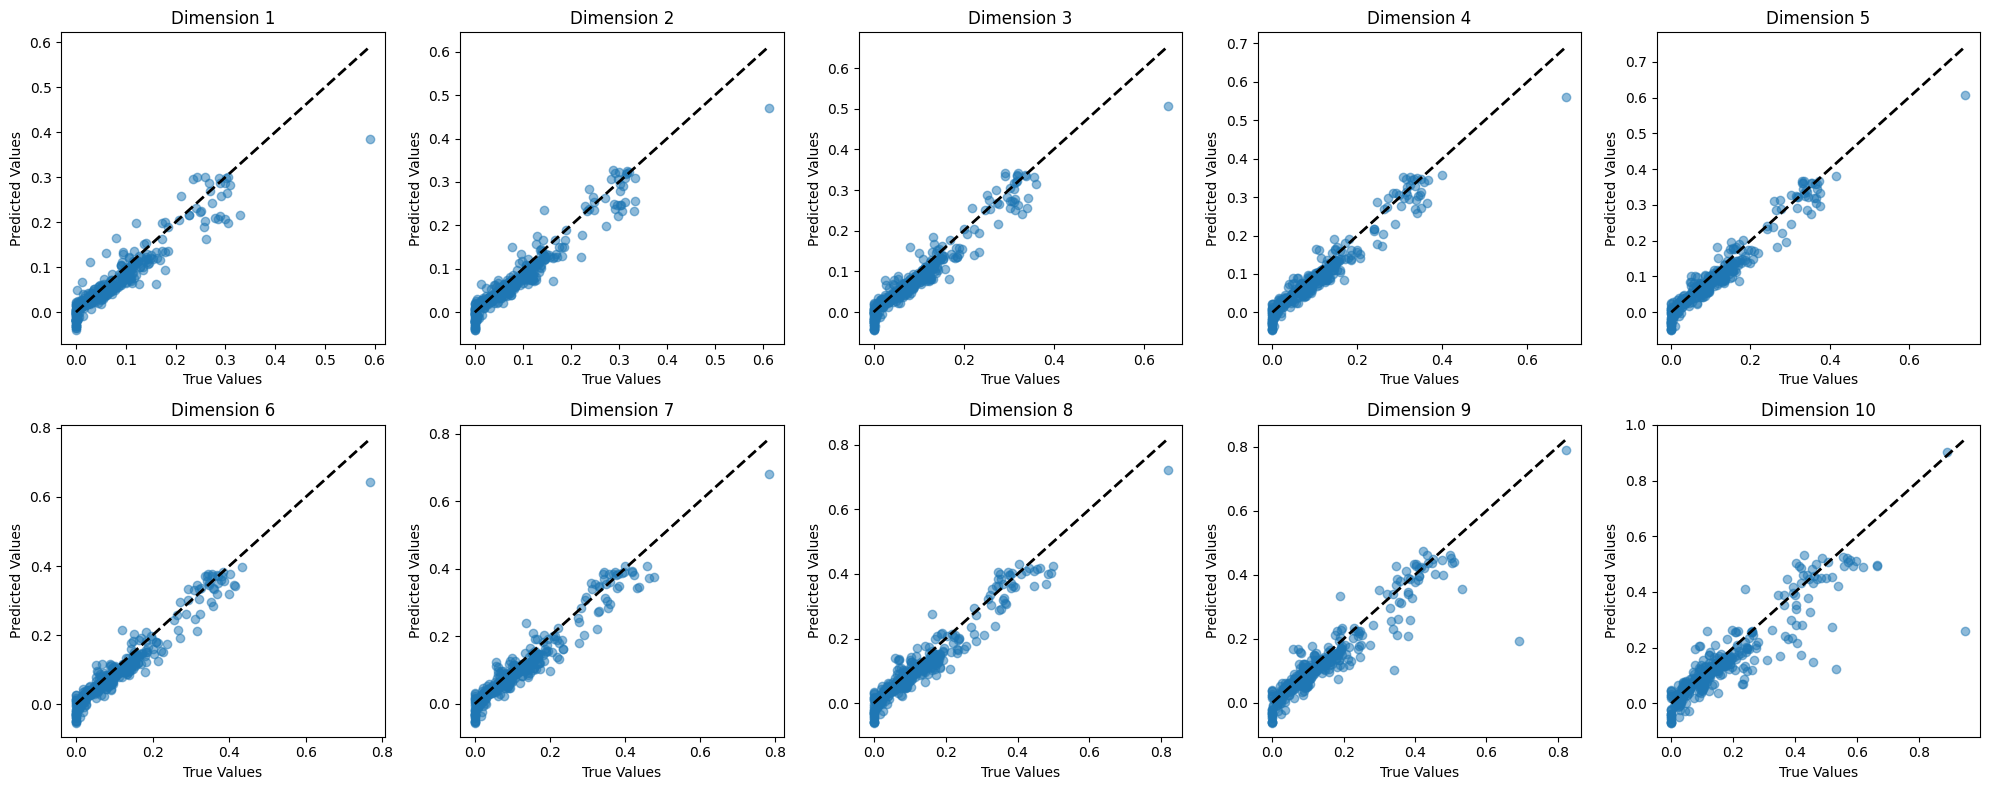

In [230]:
import matplotlib.pyplot as plt
# Example data
n_samples = y_test.shape[1]
n_outputs = y_test.shape[0]  # This should be 10 based on your output shape

# Assuming y_true and y_pred are already defined and properly shaped
n_dimensions = y_test.shape[1]  # Should be 10

# Create a figure and axes with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i in range(n_dimensions):
    ax = axes[i // 5, i % 5]  # Determine the position of the subplot
    ax.scatter(y_test[:, i], predictions[:, i], alpha=0.5)
    ax.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'k--', lw=2)  # Line y=x
    ax.set_title(f'Dimension {i+1}')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

In [231]:
scaler

MinMaxScaler()

In [232]:
numeric_cols.columns

Index(['water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'elevation',
       'landform', 'SRTM_mTPI', 'aet', 'def', 'pdsi', 'pet', 'pr', 'ro',
       'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m'],
      dtype='object')

In [233]:
drivers_gpd.columns[[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]]

Index(['water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'elevation',
       'landform', 'SRTM_mTPI', 'aet', 'def', 'pdsi', 'pet', 'pr', 'ro',
       'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m'],
      dtype='object')

In [234]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,35,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = drivers_gpd.iloc[:,[5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32]]


scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)


In [235]:
all_predicts = model.predict(scaled_numeric_df)

11224/11224 [==============================] - 29s 3ms/step


In [236]:
scaled_all_predicts = all_predicts*arr_max+arr_min

In [237]:
# scaled_all_predicts

In [238]:
percentiles_all_predicts = pd.DataFrame(scaled_all_predicts, columns=['p10','p20','p30','p40','p50','p60','p70','p80','p90','p100'] )

In [239]:
import numpy as np

# Example array with 10 columns and random data
data = scaled_all_predicts

# Define the ranges (for example, these could be percentile based or specific ranges)
ranges = [(0, 1.5), (1.5, 3), (3, 5), (5, 10), (10, 15), (15, 20), (20, 30), (30, 100)]

# Prepare an array to store the counts
counts = np.zeros((data.shape[1], len(ranges)))  # 10 columns, 8 ranges

# Define the bins for histogram based on the ranges
bins = [r[0] for r in ranges] + [ranges[-1][1]]

# Initialize an array to store the counts per row
row_counts = np.zeros((data.shape[0], len(ranges)))  # Rows in data, 8 ranges

# Loop over each row
for i in range(data.shape[0]):
    # Use np.histogram to count how many values fall into each range
    counts, _ = np.histogram(data[i, :], bins=bins)
    row_counts[i, :] = counts

# Now 'row_counts' has the count of occurrences in each range for each row
print(row_counts*10)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [240]:
summary_percentiles_all_predicts = pd.DataFrame(row_counts*10, columns=['p1_p1_5','p1_5_p_3','p3_p5','p5_p10','p10_p15','p15_p20','p20_p30','p30_'] )

In [241]:
drivers_gpd.shape

(359163, 36)

In [242]:
summary_percentiles_all_predicts.shape

(359163, 8)

In [243]:
result = pd.concat([drivers_gpd, percentiles_all_predicts, summary_percentiles_all_predicts], axis=1)

In [244]:
result.to_file("/content/drive/MyDrive/hawaii_soils/generative_simulation_results.gpkg")